# AUDIO ANALYZER & PLOTTER

Articles to link to:  

Beats solo review:  
https://www.innerfidelity.com/content/monster-beats-dr-dre-solo  
https://www.innerfidelity.com/images/MonsterBeatsSolo.pdf  

Mastering the Mix - EQ Cheat sheet  
https://www.masteringthemix.com/blogs/learn/how-to-get-a-great-tonal-balance-in-your-mix

## Imports

In [1]:
import pdb

import librosa
from librosa.feature import chroma_stft
import librosa.display

import soundfile as sf

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
# import seaborn as sns
# sns.set()

In [2]:
font = {
    'family': 'Arial',
    'weight': 'bold',
    'size': 18
}
matplotlib.rc('font', **font)

## AudioAnalyzer Class  

handles the loading and creation of a spectrum dataframe from a single audio file. 

In [18]:
class AudioAnalyzer:
    
    def __init__(self, filename, fft_size=256, input_sr=41000):
        y, sr = librosa.load(filename, sr=input_sr)
        self.y = y
        self.sr = sr
        self.fft_size = fft_size
        
    def set_fft_bin_size(self, size):
        self.fft_size = size
        self.create_df()
        
    def create_df(self):
        
        self.df = pd.DataFrame(np.abs(librosa.stft(self.y, n_fft=self.fft_size)))
        
        bins = librosa.fft_frequencies(sr=self.sr, n_fft=self.fft_size)
        
        self.df['bins'] = bins / 1000.
        
        self.df['average_amplitude'] = self.df.mean(axis=1)
        self.df = self.df[['bins', 'average_amplitude']]
        return self.df
    
    def plot_spectrum(self, min_bin=0, max_bin=None):
        max_bin = max_bin or int(self.fft_size / 2)
        self.df['average_amplitude'].iloc[min_bin:max_bin].plot()
        
        

## AudioCompare Class  

handles the comparison operations among multiple audio spectrum dataframes (all methods are classmethods only) 

includes:  
- #### get_ratio_df - will calculate and return a new dataframe containing the ratio of amplitudes, Modified / Original
- #### plot_spectrum_group - will take in audio spectrum dataframes and plot them in the same graph with the x axis being the frequency in Hz and the y axis being the average amplitude scaled

In [36]:
class AudioCompare:

    @staticmethod
    def get_max_average(dfs=[]):
        max_average = 0
        for df in dfs:
            cur_max = df.average_amplitude.max()
            max_average = cur_max if cur_max > max_average else max_average
        
        return max_average
    
    @staticmethod
    def scale_amplitudes(dfs=[]):
        max_average = AudioCompare.get_max_average(dfs)
    
        scaled_dfs = []
        for df in dfs:
            averaged = df['average_amplitude']
            df['scaled_amplitude'] = np.interp(averaged, (0., max_average), (0., 1.)) 
            scaled_dfs.append(df)
            
        return scaled_dfs
        
    @classmethod
    def get_ratio_df(cls, original, modified):
        o,m = cls.scale_amplitudes([original,modified])
        orig_scaled = o.scaled_amplitude
        mod_scaled = m.scaled_amplitude
        
        bins = original.bins
        
        ratio_df = pd.DataFrame(mod_scaled / orig_scaled)
        ratio_df['bins'] = bins
        
        curr_scaled = ratio_df.scaled_amplitude
        
        ratio_df.scaled_amplitude = np.interp(curr_scaled, (0., curr_scaled.max()), (0., 1.))
        
        return ratio_df
    
    @classmethod    
    def plot_spectrum_group(cls, dfs=[], title="Comparison of Frequency Amplitudes",
                            xlabel="Frequency (KHz)",
                            ylabel="Normalized Amplitude",                             
                            frange=[0,255],
                            ratio_df=None,
                            legend=["Original", "Modified", "Ratio (Mod:Orig)" ]
                           ):        
        
        dfs = cls.scale_amplitudes(dfs)
        
        for frame in dfs:
            frame = frame.iloc[frange[0]:frange[1]]
            plt.plot(frame['bins'], frame['scaled_amplitude'])

        if not ratio_df is None:
            rdf = ratio_df[frange[0]:frange[1]]
            plt.plot(rdf['bins'], rdf['scaled_amplitude'])
            
        plt.title(title, fontdict={'fontsize':30}, pad=20.)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(legend)
        



# == PROCESS ==

## Load audio files - Original & Modified

In [37]:
original = AudioAnalyzer('ds_test_original.wav', input_sr=48000, fft_size=4096)
modified = AudioAnalyzer('ds_test_bass_modified.wav', input_sr=48000, fft_size=4096)

## Create the DataFrames for each audio file (will be stored in .df for each AudioAnalyzer)

In [38]:
original.create_df()
modified.create_df()
pass

In [39]:
original.df.head()

,bins,average_amplitude
0,0.000000,1.718873
1,0.011719,6.299573
2,0.023438,43.519870
3,0.035156,70.147863
4,0.046875,52.640588


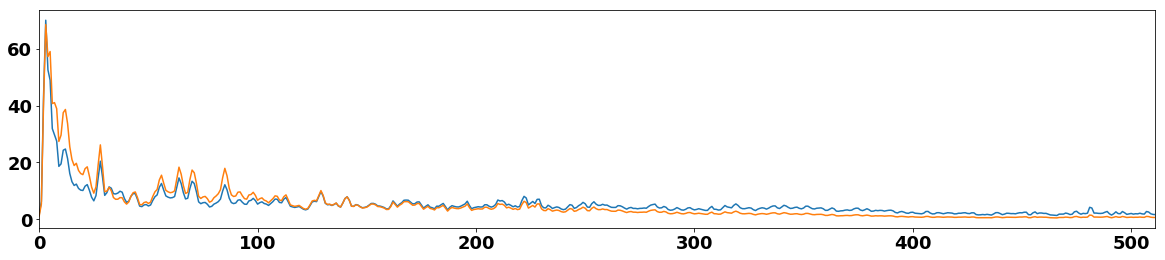

In [40]:
plt.figure(figsize=[20, 4])
original.plot_spectrum(max_bin=512)
modified.plot_spectrum(max_bin=512)

## Optionally change the fft_bin_size (default value is 256) 
#### (NOTE: will automatically regenerate dataframes when this is run)

(this is not really necessary for basic comparisons, but is available if desired)

In [41]:
original.set_fft_bin_size(8192)
modified.set_fft_bin_size(8192)

## Create a Ratio DataFrame from the Original and Modified DFs

In [42]:
# create a dataframe containing the ration of the modified amplitudes to the original amplitudes
ratio_df = AudioCompare.get_ratio_df(original=original.df, modified=modified.df)

## Plot the average frequency amplitudes (Optionally overaly ratio dataframe)

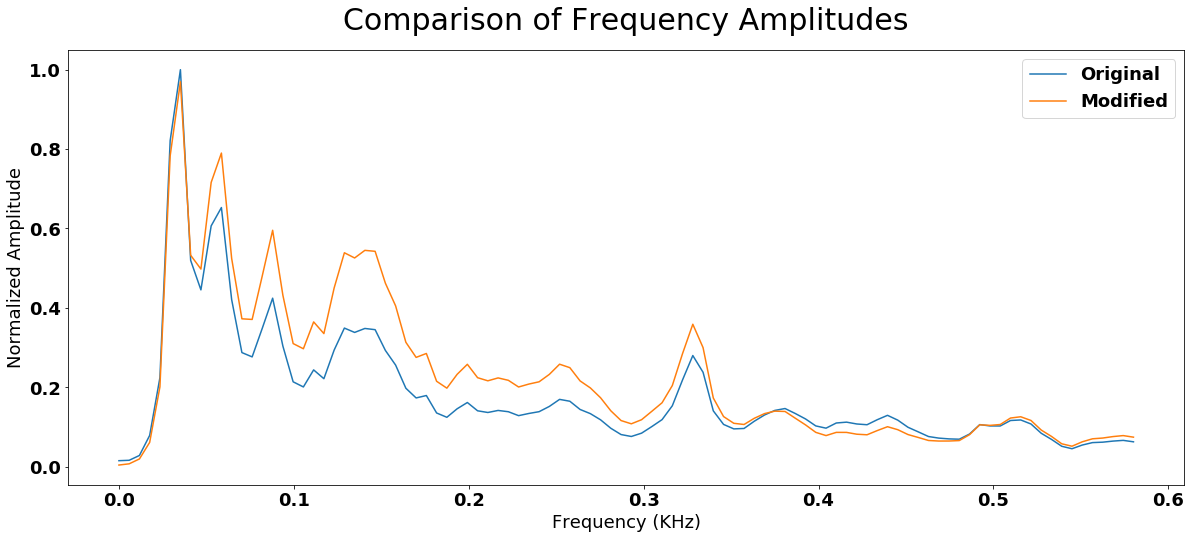

In [43]:
fig = plt.figure(figsize=(20,8))

AudioCompare.plot_spectrum_group(
    dfs=[original.df, modified.df],
    frange=(0,100),
#     ratio_df=ratio_df
)
plt.show()

# SIBELIUS TEST


In [12]:
sib_original = AudioAnalyzer('sibelius_original.wav',input_sr=48000, fft_size=4096)
sib_modified = AudioAnalyzer('sibelius_modified.wav',input_sr=48000, fft_size=4096)

In [13]:
sib_original.create_df()
sib_modified.create_df()
pass

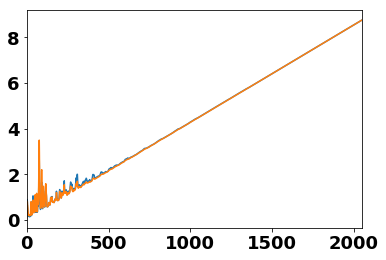

In [14]:
sib_original.plot_spectrum()
sib_modified.plot_spectrum()

In [15]:
sib_ratio_df = AudioCompare.get_ratio_df(original=sib_original.df, modified=sib_modified.df)

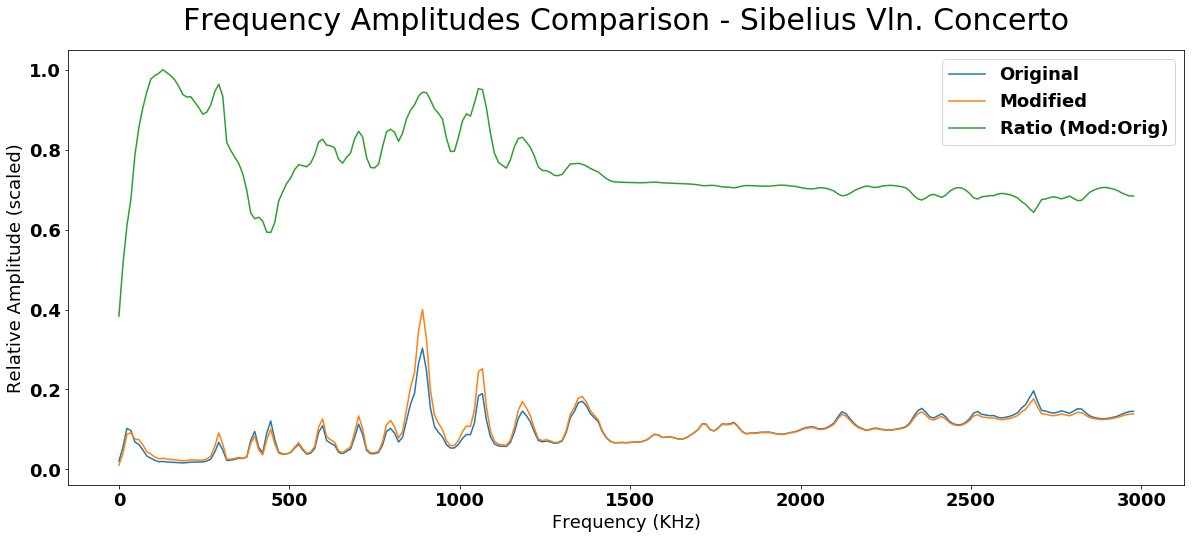

In [16]:
fig = plt.figure(figsize=(20,8))

AudioCompare.plot_spectrum_group(
    dfs=[sib_original.df, sib_modified.df],
#     frange=[0,500],
    ratio_df=sib_ratio_df,
    title="Frequency Amplitudes Comparison - Sibelius Vln. Concerto"
)
plt.show()